## Processing Sensor Data from Catalina Jemez CZO Green Pit 2
- Marc Berghouse 9/19/2020: Original format
- Zach Perzan 9/23/2020: Improved format and working PRISM concat


This array includes:
- apogee_SO110
- Vaisala_GMM220
- DecagonMPS2
- Decagon5TE

Issues:
- I'm not sure which water potential values are unrealistic

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

def plot_cols(column_list, ylabel=''):
    """Plot columns from df. Columns to plot must be in
    column_list."""
    
    n = len(column_list)

    fig, ax = plt.subplots(n, figsize=(10,3*n), tight_layout=True, sharex=True)

    for i, col in enumerate(column_list):
        ax[i].plot(df.index, df[col], label=col)
        ax[i].legend(loc='upper right')
        ax[i].set(ylabel=ylabel)
        
    return fig, ax

In [2]:
# Import each file individually as a dataframe and append it to a list of dataframes

infiles = ["../../raw_data/Catalina-Jemez/Green_Pit2/Green_pit2_co2o2_2015.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit2/Green_pit2_co2o2_2016.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit2/Green_pit2_co2o2_2017.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit2/Green_pit2_co2o2_2018.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit2/Green_pit2_soilMTP_2015.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit2/Green_pit2_soilMTP_2016.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit2/Green_pit2_soilMTP_2017.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit2/Green_pit2_soilMTP_2018.csv"]


# Lists of all dataframes
df_list = []

for infile in tqdm(infiles):
    df = pd.read_csv(infile, na_values=['NAN', -9999],  parse_dates=[0], 
                     index_col=0, skiprows=[1]) # skips the 1th row (0-indexed)
    df_list.append(df)
    
prism_path = "../../raw_data/Catalina-Jemez/Catalina-Jemez_Green_PRISM.csv"
ppt = pd.read_csv(prism_path, na_values=['NAN',-9999,-99999], skiprows=11, 
                  parse_dates=[0], index_col=0, names=['PRISM_precip.mm']) 
ppt['PRISM_precip.mm'] = pd.to_numeric(ppt['PRISM_precip.mm'])

In [3]:

columns=['ApogeeTemp_2cm.deg.C', 'ApogeeTemp_10cm.deg.C', 'ApogeeTemp_30cm.deg.C', 
            'ApogeeTemp_60cm.deg.C', 'O2_2cm.percent.0-100','O2_10cm.percent.0-100', 
            'O2_30cm.percent.0-100', 'O2_60cm.percent.0-100', 'CO2_2cm.ppm', 'CO2_10cm.ppm',
            'CO2_30cm.ppm', 'CO2_60cm.ppm', 'WaterPotential_10cm.kPa','WaterPotential_30cm.kPa',
            'DecagonMPS6Temp_10cm.deg.C','DecagonMPS6Temp_30cm.deg.C', 'SoilMoisture_10cm.m3m3',
            'SoilMoisture_30cm.m3m3', 'SoilMoisture_60cm.m3m3', 'SoilMoisture_135cm.m3m3',
            'BulkEC_10cm.dS/m', 'BulkEC_30cm.dS/m', 'BulkEC_60cm.dS/m', 'BulkEC_135cm.dS/m',
            'Decagon5TETemp_10cm.deg.C','Decagon5TETemp_30cm.deg.C', 'Decagon5TETemp_60cm.deg.C',
            'Decagon5TETemp_135cm.deg.C']


# Concatenate all individual files to a single dataframe
df = pd.concat(df_list)
df.columns = columns

# Resample everything to hourly averages since certain 
# sensors are measured on different schedules
df.sort_index(inplace=True) # Sort first
df = df.resample('1H').mean()
df
# Add on up-sampled PRISM data
# (resample daily to hourly, using the nearest value, then
#  add on as new column to df)

ppt = ppt.drop((pd.date_range('2015-01-01', '2015-10-23')), errors='ignore')
hourly_ppt = ppt.resample('1H').nearest()


df.loc[hourly_ppt.index, 'PRISM_precip.mm'] = hourly_ppt['PRISM_precip.mm']

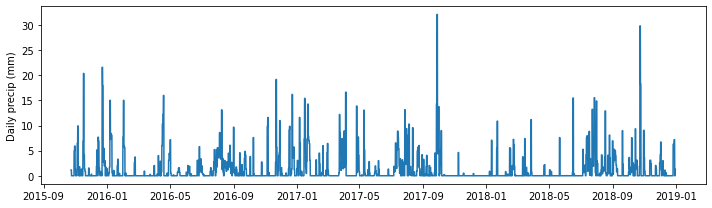

In [4]:
# Plot precip data
fig, ax = plt.subplots(figsize=(10,3), tight_layout=True)

ax.plot(df.index, df['PRISM_precip.mm'])
ax.set(ylabel='Daily precip (mm)');

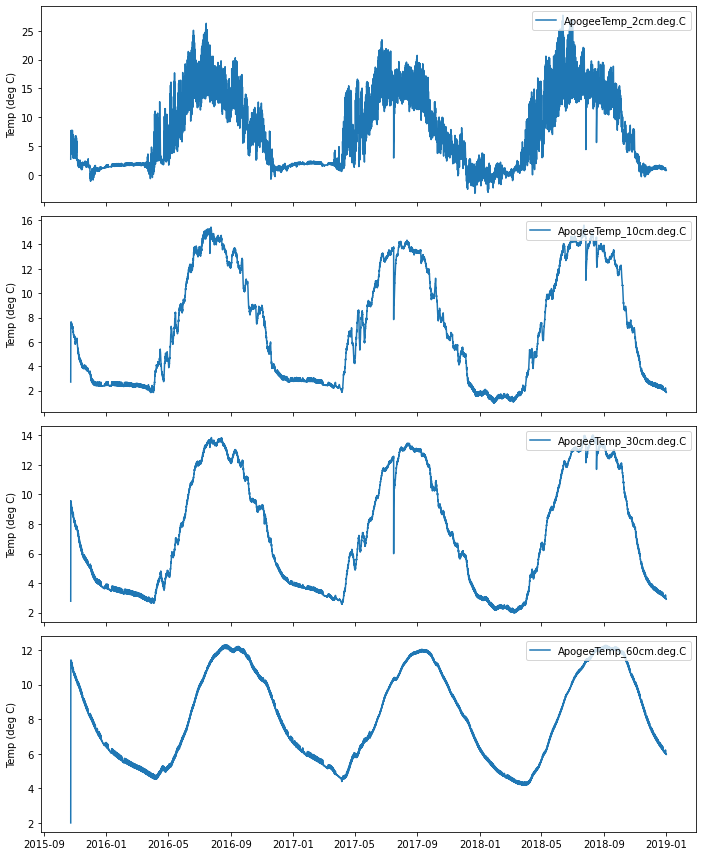

In [5]:
# Plot apogee thermistor temperature
apogee_temp_cols = [col for col in df.columns if 'ApogeeTemp' in col]
plot_cols(apogee_temp_cols, ylabel='Temp (deg C)');

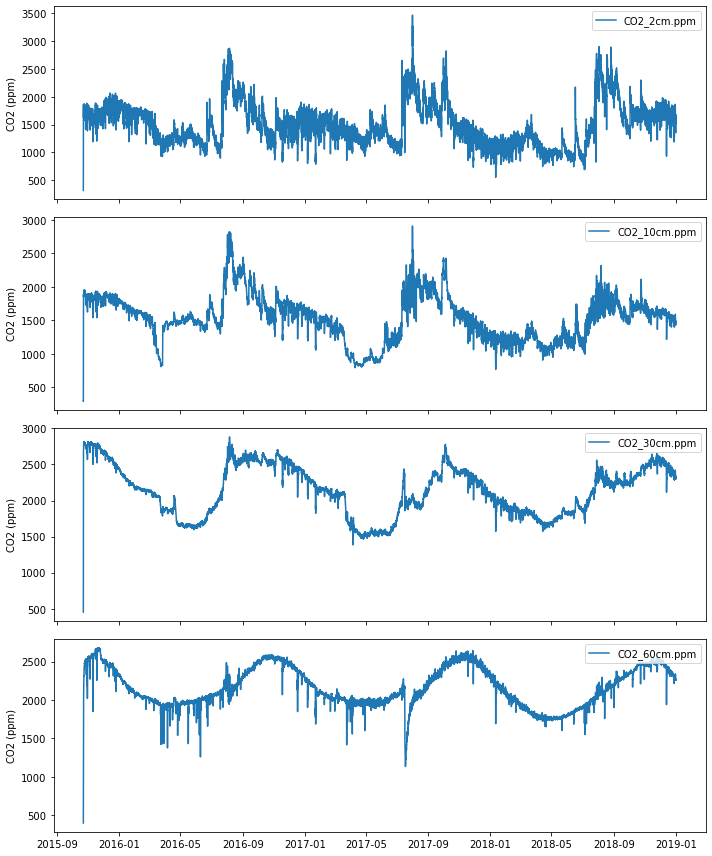

In [6]:
# Plot CO2 data
co2_cols = [col for col in df.columns if 'CO2' in col]
plot_cols(co2_cols, ylabel='CO2 (ppm)');

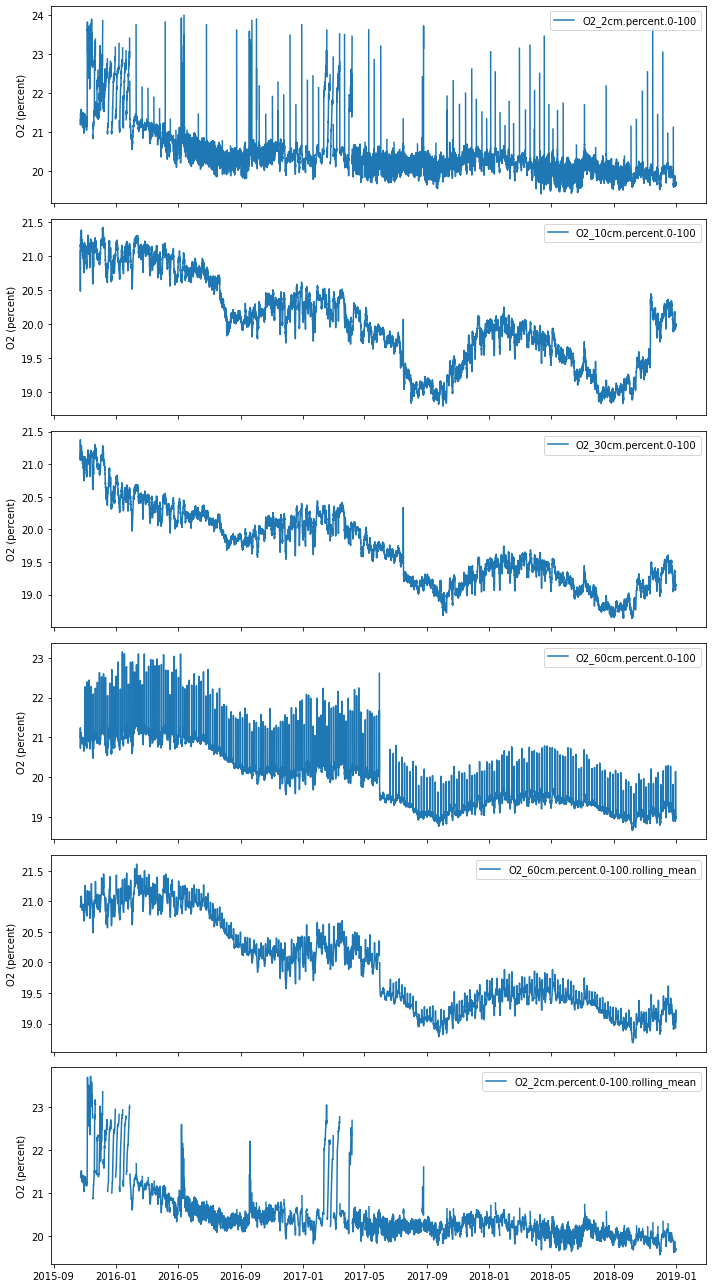

In [7]:
# Plot O2 data
df['O2_2cm.percent.0-100'].mask(df['O2_2cm.percent.0-100']>=24, inplace=True)
df['O2_10cm.percent.0-100'].mask(df['O2_10cm.percent.0-100']>=24, inplace=True)
df['O2_30cm.percent.0-100'].mask(df['O2_30cm.percent.0-100']>=24, inplace=True)
df['O2_60cm.percent.0-100'].mask(df['O2_60cm.percent.0-100']>=24, inplace=True)
df['O2_60cm.percent.0-100.rolling_mean']=df['O2_60cm.percent.0-100'].rolling(12).mean()
df['O2_2cm.percent.0-100.rolling_mean']=df['O2_2cm.percent.0-100'].rolling(12).mean()

o2_cols = [col for col in df.columns if col[:2] == 'O2']
plot_cols(o2_cols, ylabel='O2 (percent)');

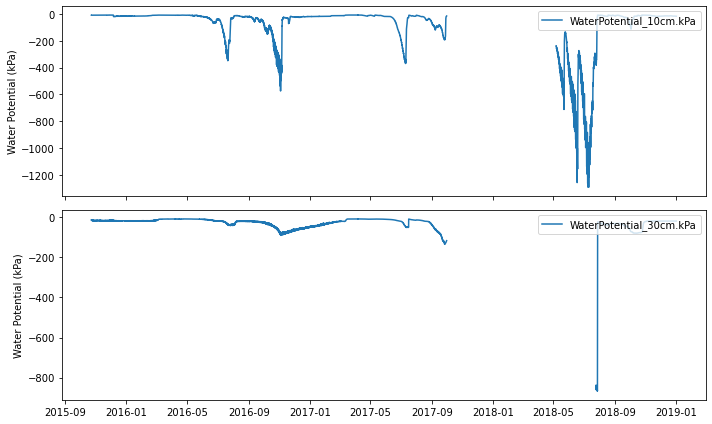

In [8]:
#Plot water potential
water_cols = [col for col in df.columns if 'Water' in col]
plot_cols(water_cols, ylabel='Water Potential (kPa)');

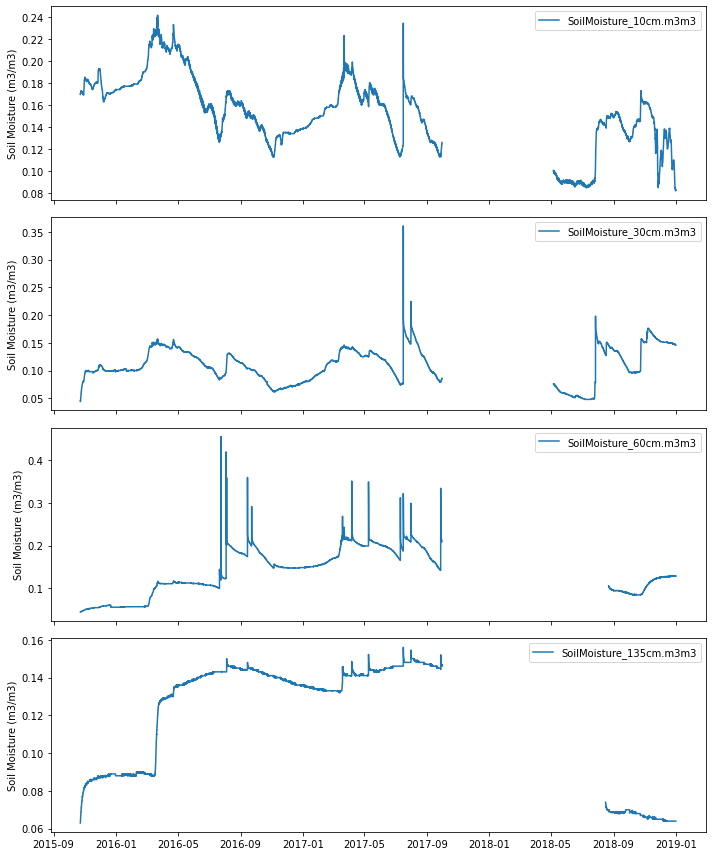

In [9]:
# Plot soil moisture data
sm_cols = [col for col in df.columns if 'SoilMoisture' in col]
plot_cols(sm_cols, ylabel='Soil Moisture (m3/m3)');

In [10]:
df=df.drop(columns='SoilMoisture_135cm.m3m3')


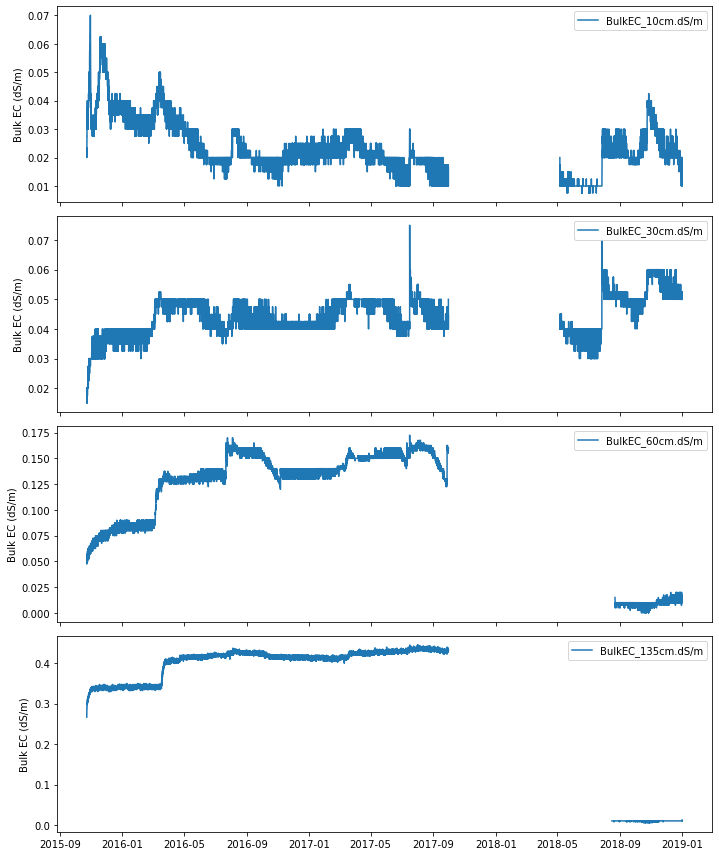

In [11]:
# Plot bulk EC
ec_cols = [col for col in df.columns if 'BulkEC' in col]
plot_cols(ec_cols, ylabel='Bulk EC (dS/m)');

In [12]:

df=df.drop(columns='BulkEC_135cm.dS/m')



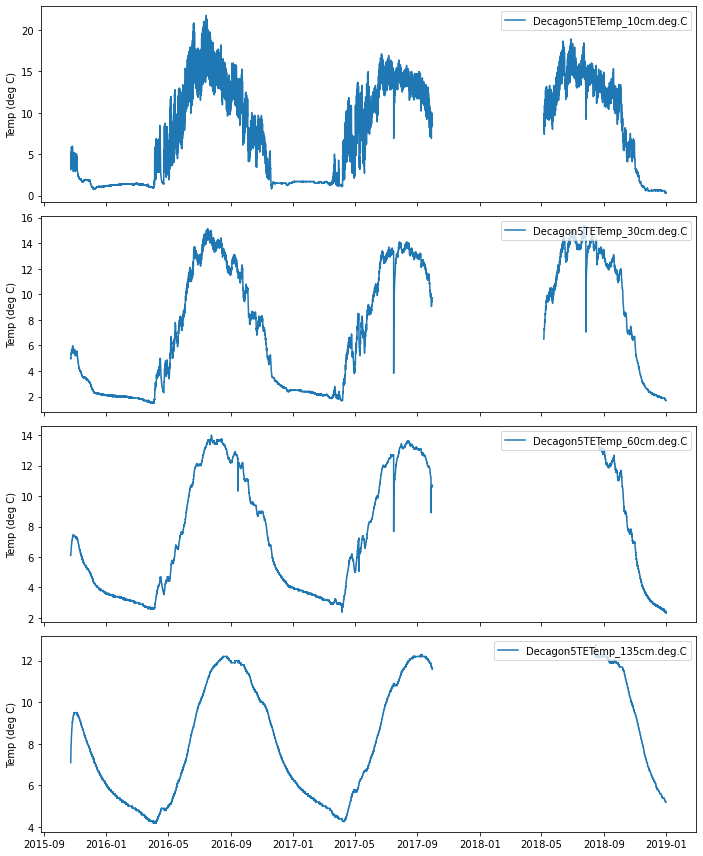

In [13]:
# Plot soil temperature from Decagon 5TE
dec_temp_cols = [col for col in df.columns if 'Decagon5TETemp' in col]

# There are several erroneous values less than -5 deg C
for col in dec_temp_cols:
    df[df[col] < -5] = np.nan
plot_cols(dec_temp_cols, ylabel='Temp (deg C)');

In [14]:
df=df.drop(columns='Decagon5TETemp_10cm.deg.C')
df=df.drop(columns='Decagon5TETemp_30cm.deg.C')
df=df.drop(columns='Decagon5TETemp_60cm.deg.C')
df=df.drop(columns='Decagon5TETemp_135cm.deg.C')
df=df.drop(columns='DecagonMPS6Temp_10cm.deg.C')
df=df.drop(columns='DecagonMPS6Temp_30cm.deg.C')




In [15]:
output=df.copy()
outfile = '../../processed_data/Catalina-Jemez/Green_Pit2_processed.csv'
output.to_csv(outfile, na_rep=-99999, index_label='DateTime.MST')

In [16]:
output

,ApogeeTemp_2cm.deg.C,ApogeeTemp_10cm.deg.C,ApogeeTemp_30cm.deg.C,ApogeeTemp_60cm.deg.C,O2_2cm.percent.0-100,O2_10cm.percent.0-100,O2_30cm.percent.0-100,O2_60cm.percent.0-100,CO2_2cm.ppm,CO2_10cm.ppm,...,WaterPotential_30cm.kPa,SoilMoisture_10cm.m3m3,SoilMoisture_30cm.m3m3,SoilMoisture_60cm.m3m3,BulkEC_10cm.dS/m,BulkEC_30cm.dS/m,BulkEC_60cm.dS/m,PRISM_precip.mm,O2_60cm.percent.0-100.rolling_mean,O2_2cm.percent.0-100.rolling_mean
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2015-10-23 09:00:00,2.693667,2.709667,2.772333,2.008667,21.195667,21.07900,21.07400,21.00000,316.896333,293.755333,...,-13.466667,0.169667,0.04500,0.043333,0.023333,0.0200,0.0500,NaN,NaN,NaN
2015-10-23 10:00:00,3.836250,4.534750,5.476000,6.723750,NaN,20.48475,21.37675,21.24125,320.813250,290.824750,...,-14.275000,0.169500,0.04450,0.043000,0.022500,0.0175,0.0475,NaN,NaN,NaN
2015-10-23 11:00:00,6.501000,7.474500,9.389000,11.158750,NaN,21.16725,21.08175,20.80575,1237.793750,1023.759250,...,-14.625000,0.170250,0.04400,0.043000,0.022500,0.0175,0.0475,NaN,NaN,NaN
2015-10-23 12:00:00,6.421750,7.604750,9.547000,11.335250,21.335250,21.15525,21.06975,20.72875,1749.191750,1464.099250,...,-15.125000,0.170000,0.04475,0.043000,0.022500,0.0200,0.0500,NaN,NaN,NaN
2015-10-23 13:00:00,6.927500,7.621000,9.568750,11.389000,21.245750,21.14825,21.06300,20.74125,1815.448000,1649.119750,...,-14.975000,0.170500,0.04500,0.043000,0.020000,0.0175,0.0525,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,0.741000,1.868250,2.919000,5.965000,19.726000,20.00575,19.16475,19.00025,1533.149500,1463.992250,...,-18.450000,0.083000,0.14600,0.128250,0.010000,0.0525,0.0125,NaN,19.216458,19.705667
2018-12-31 20:00:00,0.741000,1.863000,2.919000,5.965000,19.711000,20.00000,19.15925,19.00125,1596.235000,1466.987000,...,-18.450000,0.083000,0.14600,0.128750,0.015000,0.0500,0.0100,NaN,19.222125,19.703583
2018-12-31 21:00:00,0.750500,1.861000,2.917250,5.965000,19.704250,20.00000,19.15725,18.97175,1633.763750,1474.570750,...,-18.425000,0.083000,0.14600,0.129000,0.020000,0.0500,0.0150,NaN,19.124417,19.699813
